In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from sklearn.preprocessing import minmax_scale
from statsmodels.tsa.stattools import coint
today = datetime.today().strftime("%Y%m%d") 
# start = (datetime.today() - timedelta()).strftime("%Y%m%d") 
# print(start, today)
pd.options.display.float_format = '{:.6f}'.format

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
cd drive/My Drive/algorithmtrading/pair_trading

/content/drive/My Drive/algorithmtrading/pair_trading


In [ ]:
def one_day(temp,test_day):
    
    begin = np.where( np.array(temp.index) > str(test_day))[0][0]
    end = np.where( str(test_day+1) > np.array(temp.index) )[0][-1]
    
    if len(temp.iloc[begin:end])==0:
        print(test_day,'는 공휴일 입니다.')
    else:
        return temp.iloc[begin-1:end]

# 1. 과거 1분단위 데이터 받아오기

In [ ]:
now = '20210120'

kodex200 = pd.read_pickle('KODEX 200(m)_'+now)
tiger200 = pd.read_pickle('TIGER 200(m)_'+now)

temp =  pd.merge(left = kodex200 , right = tiger200, how = "inner", on = "체결시간")
temp = temp.set_index('체결시간')
temp.columns = ['kodex200','volume','tiger200','volume']
temp = temp[['kodex200','tiger200']]

temp['kodex200']=pd.to_numeric(temp['kodex200'])
temp['tiger200']=pd.to_numeric(temp['tiger200'])

for i in range(len(temp)):
    if temp['kodex200'].iloc[i] < 0:
        temp['kodex200'].iloc[i] = -temp['kodex200'].iloc[i]
    if temp['tiger200'].iloc[i] < 0:
        temp['tiger200'].iloc[i] = -temp['tiger200'].iloc[i]


temp['tiger200'] = temp['tiger200']
temp['spread'] = temp['kodex200'] - temp['tiger200']
temp['kodex200_cumret'] = np.log(temp['kodex200']/temp['kodex200'][0])
temp['tiger200_cumret'] = np.log(temp['tiger200']/temp['tiger200'][0])
temp['ma10_spread'] = temp['spread'].rolling(window=10, center=False).mean()

temp

,kodex200,tiger200,spread,kodex200_cumret,tiger200_cumret,ma10_spread
체결시간,,,,,,
20200102100000,29221,29176,45,0.000000,0.000000,nan
20200102100100,29192,29152,40,-0.000993,-0.000823,nan
20200102100200,29206,29166,40,-0.000513,-0.000343,nan
20200102100300,29192,29152,40,-0.000993,-0.000823,nan
20200102100400,29152,29112,40,-0.002364,-0.002196,nan
...,...,...,...,...,...,...
20210119151600,42700,42660,40,0.379311,0.379915,25.000000
20210119151700,42700,42675,25,0.379311,0.380267,25.000000
20210119151800,42720,42690,30,0.379780,0.380618,27.000000


# 2. 일 단위로 데이터 저장하기 + 당일 수익률 계산

In [ ]:
df = {}
calender = []
for date in range(20201021,20210120):
    if 20201231 < date < 20210100:
        continue
    temps = pd.DataFrame()
    temps = one_day(temp,date)
    try:      
        temps['kodex200_dayret'] = np.log(temps['kodex200']/temps['kodex200'][0])
        temps['tiger200_dayret'] = np.log(temps['tiger200']/temps['tiger200'][0])
        temps['spread_cumret'] = temps['kodex200_cumret'] -temps['tiger200_cumret']
        temps['spread_dayret']= temps['kodex200_dayret'] - temps['tiger200_dayret'] 
        df[str(date)] = temps
        if len(temps) != 0:
            calender.append(str(date))
    except:
        pass
calender

# 3. 그래프 그리기

In [ ]:
for date in calender[-10:]:
    plt.rcParams["figure.figsize"] = (20, 10)
    df[date]['spread'].plot()
    # df[date]['ma10_spread'].plot()
    # temp_high = df[date]['ma10_spread'] +20
    # temp_low = df[date]['ma10_spread']-20
    # temp_high.plot(linestyle='--')
    # temp_low.plot(linestyle='--')
    # df[date]['kodex200'].plot()
    # df[date]['tiger200'].plot()
    # plt.axhline((0.0003), color='red', linestyle='--')
    # plt.axhline((-0.0003), color='red', linestyle='--')
    plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (30, 10)
# temp['kodex200_cumret'].plot()
# temp['kodex200_cumret'].plot()
# temp['tiger200_cumret'].plot()
temp['kodex200'].plot()
temp['tiger200'].plot()
# temp['ma30'].plot()

# 4. 스프레드 확인

In [3]:
cd bidask

/content/drive/My Drive/algorithmtrading/pair_trading/bidask


In [4]:
now = '20210122'

kodex200_bidask = pd.read_pickle('KODEX 200_'+now)
tiger200_bidask = pd.read_pickle('TIGER 200_'+now)

bidask =  pd.merge(left = kodex200_bidask , right = tiger200_bidask, how = "inner", on = "time")
bidask.columns = ['kodex_bid','kodex_ask','tiger_bid','tiger_ask']
kodex_ask = bidask['kodex_ask']
kodex_bid = bidask['kodex_bid']
tiger_ask = bidask['tiger_ask']
tiger_bid = bidask['tiger_bid']
bidask

,kodex_bid,kodex_ask,tiger_bid,tiger_ask
time,,,,
095242,43525,43515,43510,43500
095244,43525,43515,43510,43500
095247,43520,43515,43510,43500
095249,43515,43510,43505,43500
095252,43515,43505,43500,43490
...,...,...,...,...
151950,43245,43240,43225,43215
151952,43255,43250,43235,43215
151955,43260,43255,43245,43225


## - bidask 스프레드

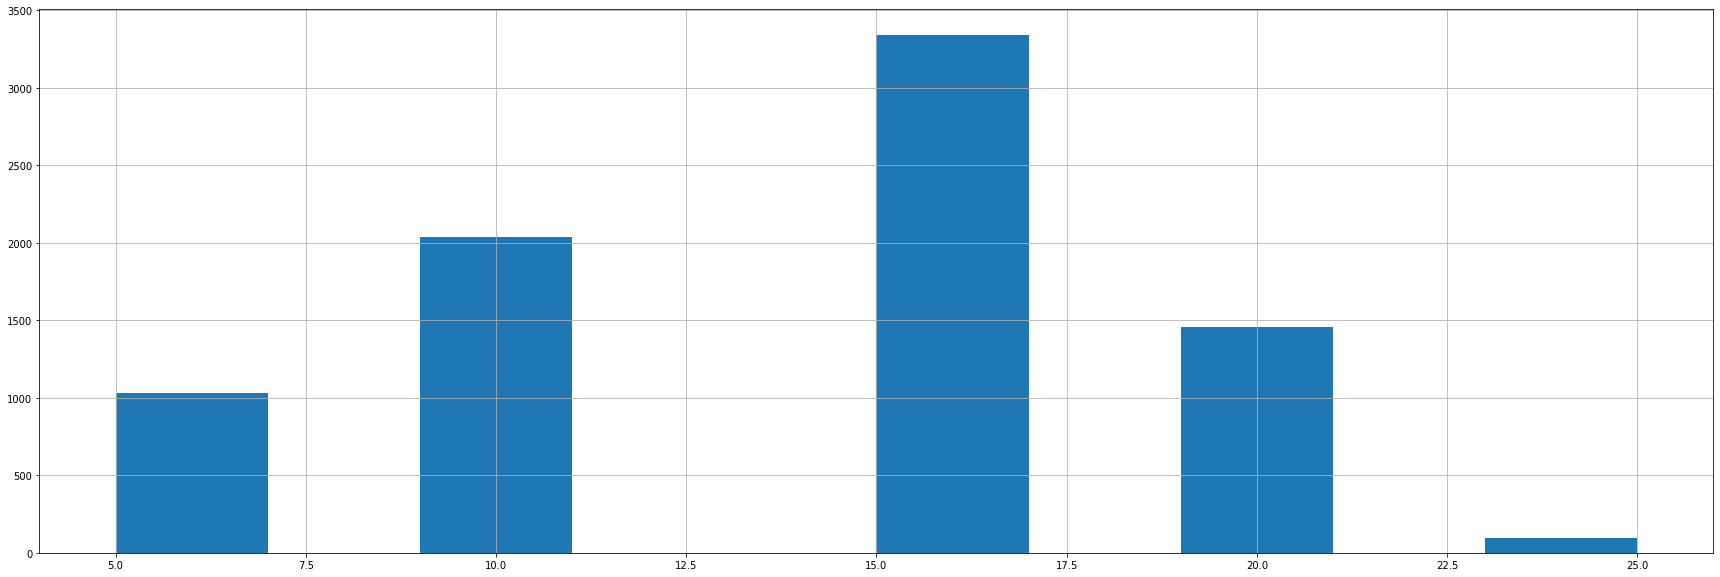

In [8]:
plt.rcParams["figure.figsize"] = (30, 10)
bidask_spread = tiger_bid-tiger_ask
bidask_spread.hist()

# tiger_ask_kodex_bid spread freaquency    (청산포지션)

-30    3058
-35    3021
-25     959
-40     781
-20     105
-45      27
-15       6
-50       3
-55       1
dtype: int64


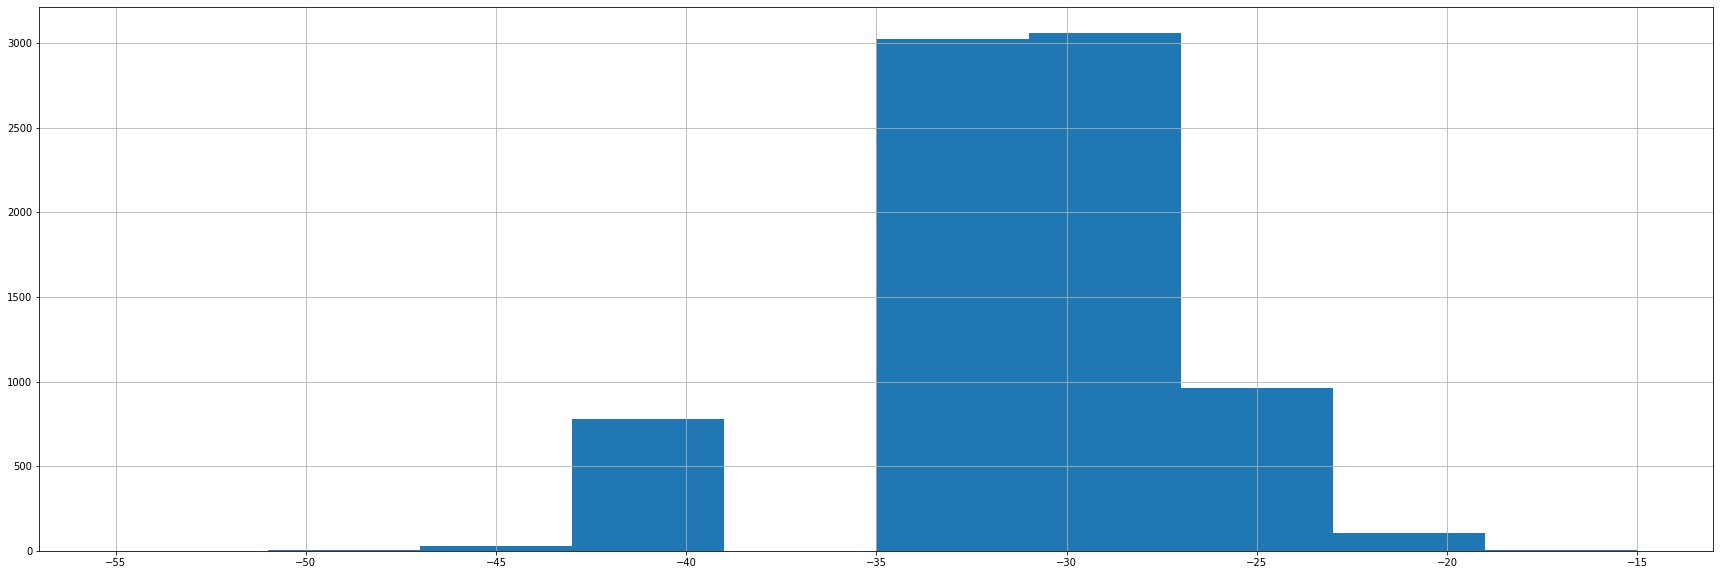

In [9]:
tiger_ask_kodex_bid = tiger_ask - kodex_bid
tiger_ask_kodex_bid.hist()
freq = tiger_ask_kodex_bid.value_counts() 
print(freq)

# kodex_ask_tiger_bid spread freaquency (포지션시작)

10    3296
15    1922
5     1760
20     735
25     193
0       34
30      21
dtype: int64


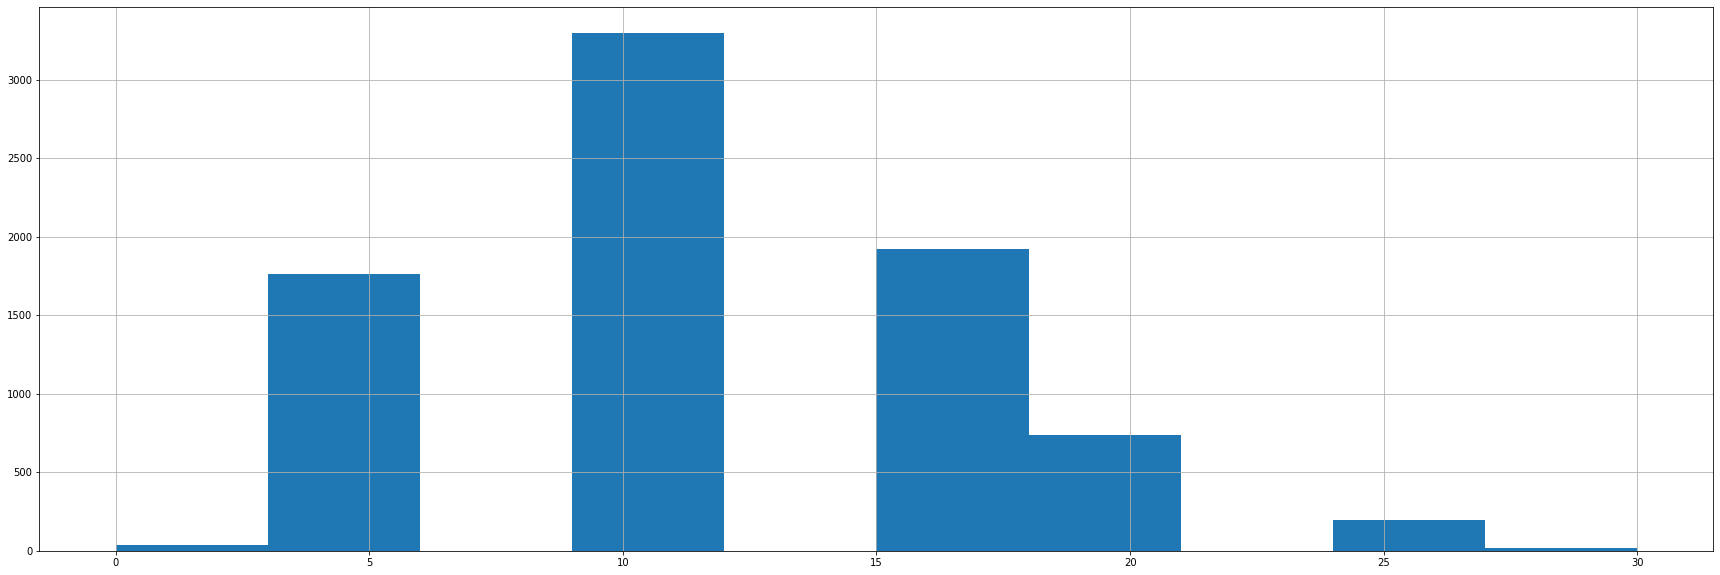

In [10]:
kodex_ask_tiger_bid = kodex_ask - tiger_bid
kodex_ask_tiger_bid.hist()
freq = kodex_ask_tiger_bid.value_counts() 
print(freq)

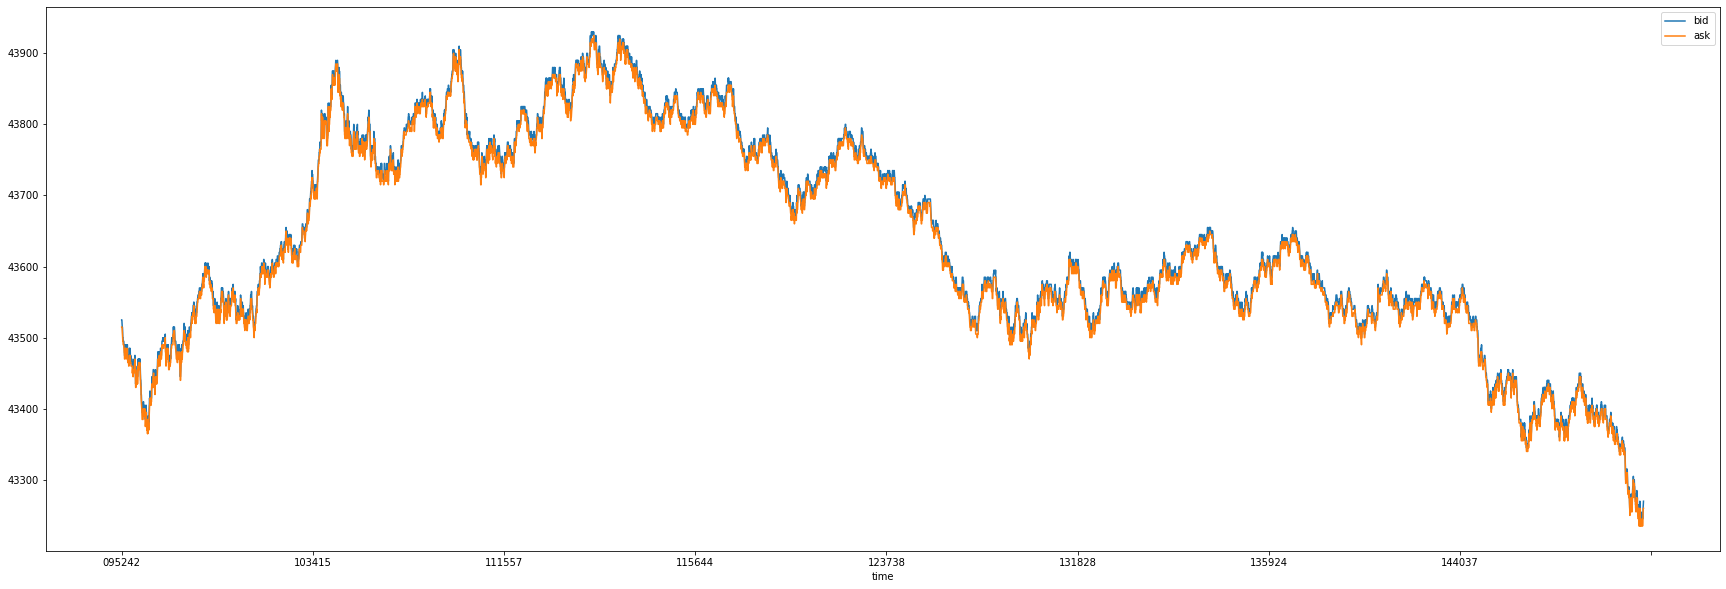

In [6]:
kodex200_bidask.plot()

# 시뮬레이션

In [ ]:
profit = 0
profits = {}

kodex = 20
tiger = 20

lev = 1

spread_start = [0,5,10,15,20,35,40]
spread_finish = [-40,-35,-30,-25,-20,-15,-10,-5,0]

for j in spread_start:
    for k in spread_finish:
        if j + k < 0:
            continue
        profit = 0
        t = 0
        for i in range(len(bidask)):
            if bidask['kodex_ask'].iloc[i] - bidask['tiger_bid'].iloc[i] >= j and tiger<=39:
                kodex -= 2
                tiger += 2
                profit += bidask['kodex_ask'].iloc[i]*lev - bidask['tiger_bid'].iloc[i]*lev
                print('start',i,'번째거래 / ','  ask:',bidask['kodex_ask'].iloc[i],'  bid:', bidask['tiger_bid'].iloc[i],'  profit:',profit)
                t += 2
                continue
            if bidask['tiger_ask'].iloc[i] - bidask['kodex_bid'].iloc[i] >= k and tiger > 20:
                profit += bidask['tiger_ask'].iloc[i]*(tiger - 20) - bidask['kodex_bid'].iloc[i]*(tiger-20)
                tiger = 20
                kodex = 20
                print('finish',i,'번째거래 / ','  ask:',bidask['tiger_ask'].iloc[i],'  bid:', bidask['kodex_bid'].iloc[i],'  profit:',profit)       
                t += 2
        profits[(j,k,t)] = profit - t*6
        print('-------------------------------------------------------------------------------------------------------------------')

profits